---
# Setup
1. Environment (variables & dependencies)
2. Application

In [4]:
#Env Var
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')
GEMINI_API_KEY = userdata.get('gemini')

In [5]:
#Dependencies
!pip install -U langsmith langchain-google-genai langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.4
    Uninstalling langsmith-0.4.4:
      Successfully uninstalled langsmith-0.4.4
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

---
## Application

In [9]:
#@title Indexing & Retrieval
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings # Import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using GoogleGenerativeAIEmbeddings
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GEMINI_API_KEY), # Use GoogleGenerativeAIEmbeddings
)

# With langchain we can easily turn any vector store into a retrieval component:
retriever = vectorstore.as_retriever(k=6)

In [10]:
#@title Generation
from langchain_google_genai import ChatGoogleGenerativeAI # Import ChatGoogleGenerativeAI
from langsmith import traceable

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=1, google_api_key=GEMINI_API_KEY) # Use ChatGoogleGenerativeAI

# Add decorator so this function is traced in LangSmith
@traceable()
def rag_bot(question: str) -> dict:
    # LangChain retriever will be automatically traced
    docs = retriever.invoke(question)
    docs_string = "\n\n".join(doc.page_content for doc in docs)

    instructions = f"""You are a helpful assistant who is good at analyzing source information and answering questions.       Use the following source documents to answer the user's questions.       If you don't know the answer, just say that you don't know.       Use three sentences maximum and keep the answer concise.

Documents:
{docs_string}"""

    # langchain ChatModel will be automatically traced
    ai_msg = llm.invoke([
            {"role": "system", "content": instructions},
            {"role": "user", "content": question},
        ],
    )

    return {"answer": ai_msg.content, "documents": docs}

---
# Dataset

In [17]:
from langsmith import Client

client = Client()

In [ ]:
from langsmith import Client

client = Client()

# Define the examples for the dataset
examples = [
    {
        "inputs": {"question": "How does the ReAct agent use self-reflection? "},
        "outputs": {"answer": "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs."},
    },
    {
        "inputs": {"question": "What are the types of biases that can arise with few-shot prompting?"},
        "outputs": {"answer": "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias."},
    },
    {
        "inputs": {"question": "What are five types of adversarial attacks?"},
        "outputs": {"answer": "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming."},
    }
]

# Create the dataset and examples in LangSmith
dataset_name = "Lilian Weng Blogs Q&A"
dataset = client.create_dataset(dataset_name=dataset_name)
client.create_examples(
    dataset_id=dataset.id,
    examples=examples
)

---
# Evaluators

## Corectness

In [11]:
from typing_extensions import Annotated
from pydantic import BaseModel, Field

# Grade output schema
class CorrectnessGrade(BaseModel):
    # Note that the order in the fields are defined is the order in which the model will generate them.
    # It is useful to put explanations before responses because it forces the model to think through
    # its final response before generating it:
    explanation: str = Field(..., description="Explain your reasoning for the score")
    correct: bool = Field(..., description="True if the answer is correct, False otherwise.")

# Grade prompt
correctness_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER.

Here is the grade criteria to follow:
(1) Grade the student answers based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student answer does not contain any conflicting statements.
(3) It is OK if the student answer contains more information than the ground truth answer, as long as it is factually accurate relative to the  ground truth answer.

Correctness:
A correctness value of True means that the student's answer meets all of the criteria.
A correctness value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

# Grader LLM
grader_llm_correctness = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0, google_api_key=GEMINI_API_KEY).with_structured_output(CorrectnessGrade, method="json_mode", strict=True)


def correctness(inputs: dict, outputs: dict, reference_outputs: dict) -> dict:
    """An evaluator for RAG answer accuracy"""
    answers = f"""\
QUESTION: {inputs['question']}
GROUND TRUTH ANSWER: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""

    # Run evaluator
    grade: CorrectnessGrade = grader_llm_correctness.invoke([
        {"role": "system", "content": correctness_instructions},
        {"role": "user", "content": answers}
    ])
    return {"score": grade.correct}

## Relevance

In [21]:
from typing_extensions import Annotated
from pydantic import BaseModel, Field

# Grade output schema
class RelevanceGrade(BaseModel):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    relevant: Annotated[bool, ..., "Provide the score on whether the answer addresses the question"]

# Grade prompt
relevance_instructions="""You are a teacher grading a quiz.

You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION
(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Relevance:
A relevance value of True means that the student's answer meets all of the criteria.
A relevance value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

# Grader LLM
grader_llm_relevance = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=1, google_api_key=GEMINI_API_KEY).with_structured_output(RelevanceGrade, method="json_mode", strict=True)


def relevance(inputs: dict, outputs: dict) -> dict:
    """A simple evaluator for RAG answer helpfulness."""
    answers = f"""\
QUESTION: {inputs['question']}
STUDENT ANSWER: {outputs['answer']}"""

# Run evaluator
    grade: RelevanceGrade = grader_llm_relevance.invoke([
        {"role": "system", "content": relevance_instructions},
        {"role": "user", "content": answers}
    ])
    return {"score": grade.relevant}

## Groundness

In [13]:
from typing_extensions import Annotated
from pydantic import BaseModel, Field

# Grade output schema
class GroundedGrade(BaseModel):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    grounded: Annotated[bool, ..., "Provide the score on if the answer hallucinates from the documents"]

# Grade prompt
grounded_instructions = """You are a teacher grading a quiz.

You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS.
(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Grounded:
A grounded value of True means that the student's answer meets all of the criteria.
A grounded value of False means that the student's answer does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""


# Grader LLM
grader_llm_groundedness = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=1, google_api_key=GEMINI_API_KEY).with_structured_output(GroundedGrade, method="json_mode", strict=True)


def groundedness(inputs: dict, outputs: dict) -> dict:
    """A simple evaluator for RAG answer groundedness."""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    answers = f"FACTS: {doc_string}\nSTUDENT ANSWER: {outputs['answer']}"

# Run evaluator
    grade: GroundedGrade = grader_llm_groundedness.invoke([
        {"role": "system", "content": grounded_instructions},
        {"role": "user", "content": answers}
    ])
    return {"score": grade.grounded}

## Retrieval Relevance

In [22]:
from typing_extensions import Annotated
from pydantic import BaseModel, Field

# Grade output schema
class RetrievalRelevanceGrade(BaseModel):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    relevant: Annotated[bool, ..., "True if the retrieved documents are relevant to the question, False otherwise"]

# Grade prompt
retrieval_relevance_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION and a set of FACTS provided by the student.

Here is the grade criteria to follow:
(1) You goal is to identify FACTS that are completely unrelated to the QUESTION
(2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant
(3) It is OK if the facts have SOME information that is unrelated to the question as long as (2) is met

Relevance:
A relevance value of True means that the FACTS contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant.
A relevance value of False means that the FACTS are completely unrelated to the QUESTION.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

# Grader LLM
grader_llm_rrelevance = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=1, google_api_key=GEMINI_API_KEY).with_structured_output(RetrievalRelevanceGrade, method="json_mode", strict=True)


def retrieval_relevance(inputs: dict, outputs: dict) -> dict:
    """An evaluator for document relevance"""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    answer = f"FACTS: {doc_string}\nQUESTION: {inputs['question']}"

# Run evaluator
    grade: RetrievalRelevanceGrade = grader_llm_rrelevance.invoke([
        {"role": "system", "content": retrieval_relevance_instructions},
        {"role": "user", "content": answer}
    ])
    return {"score": grade.relevant}

---
# Run

In [ ]:
def target(inputs: dict) -> dict:
    return rag_bot(inputs["question"])

experiment_results = client.evaluate(
    target,
    data=dataset_name,
    evaluators=[correctness, groundedness, relevance, retrieval_relevance],
    experiment_prefix="rag-doc-relevance",
    metadata={"version": "LCEL context, gpt-4-0125-preview"},
)
# Explore results locally as a dataframe if you have pandas installed
# experiment_results.to_pandas()

## Export Results to Pandas

In [27]:
# Export experiment results to a pandas DataFrame
df_results = experiment_results.to_pandas()

# Display the first 5 rows of the DataFrame
display(df_results.head())

Output hidden; open in https://colab.research.google.com to view.

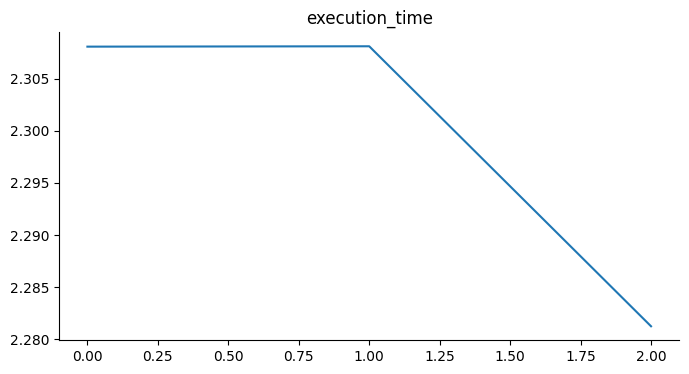

In [28]:
from matplotlib import pyplot as plt
_df_48['execution_time'].plot(kind='line', figsize=(8, 4), title='execution_time')
plt.gca().spines[['top', 'right']].set_visible(False)